## Activity 2.3 : Predicting HDB resale price
In this activity, we will learn:

*   HDB resale price dataset 
*   Load and preprocess the dataset
*   Split the dataset for training and testing
*   Define, compile and train a neural network model
*   Evaluate the model


### Resale Flat Prices
The Resale Flat Prices dataset can be downloaded at https://data.gov.sg/dataset/resale-flat-prices.  It contains the following data, month of the transaction, the town, flat type, block, street name, story range, floor area, flat model, lease commence date, remaining lease and Resale price. 

What we want to do is to train a neural network model that is able to predict the resale price of a particular HDB flat, given some information like town, lease commnce date and floor area for example.


### Mount Google Drive

Mount your Google Drive on your runtime using an authorization code.

Follow the instruction on the screen to authorise Colab accessing your drive. On your Google Drive, you can access you files prepend with “/content/drive/MyDrive/”

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# change working director
# %cd "/content/drive/MyDrive/Colab Notebooks/goML"

### Import necessary libraries and dataset

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

### Process the dataset

If you download the dataset from data.gov.sg, unzip the files and use resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv.  At the time of this writing, the file contains about 94k transaction records.  We pandas to read the file into a dataframe. As you can see, we use a separate copy so we do not need to reload everytime we alter the dataframe

In [ ]:
file_url = "data/resale-flat-prices-from-jan-2017-onwards.csv"
data = pd.read_csv(file_url)
dataframe = data.copy()
dataframe.shape

Let us have a peek at the dataset

In [ ]:
dataframe.head()

Let's do some cleaning up of the dataset

In [ ]:
#let's break date to years, months
dataframe['date'] = pd.to_datetime(dataframe['month'])
dataframe['month'] = dataframe['date'].apply(lambda date:date.month)
dataframe['year'] = dataframe['date'].apply(lambda date:date.year)

#Get number of years left on lease as a continuous number (ignoring months)
dataframe['remaining_lease'] = dataframe['remaining_lease'].apply(lambda remaining_lease:remaining_lease[:2])

#Get storey range as a continuous number
dataframe['storey_range'] = dataframe['storey_range'].apply(lambda storey_range:storey_range[:2])

In [ ]:
dataframe.head()

**Geocoding**.  We would also like to geocode the addresses. However since geocoders usually have a limit to the amount of addresses we can geocode for free, I decided to geocode the towns only
We used Geopy and Geopanda as shown here https://towardsdatascience.com/geocode-with-python-161ec1e62b89

In [ ]:
#Concat address
dataframe['address'] = dataframe['block'].map(str) + ', ' + dataframe['street_name'].map(str) + ', Singapore' 
dataframe.head()

In [ ]:
# !pip install geopandas 
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [ ]:
#Geocode by town (Singapore is so small that geocoding by addresses might not make much difference compared to geocoding to town)

town = [x for x in dataframe['town'].unique().tolist() 
            if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(town)):
    # remove things that does not seem usefull here
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        loc = geolocator.geocode(town[i])
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
        print('The geographical coordinate of location are {}, {}.'.format(loc.latitude, loc.longitude))
    except:
        # in the case the geolocator does not work, then add nan element to list
        # to keep the right size
        latitude.append(np.nan)
        longitude.append(np.nan)
# create a dataframe with the locatio, latitude and longitude
df_ = pd.DataFrame({'town':town, 
                    'latitude': latitude,
                    'longitude':longitude})
# merge on Restaurant_Location with rest_df to get the column 
dataframe = dataframe.merge(df_, on='town', how='left')

In [ ]:
dataframe.head()

Next we can drop some columns which is not useful for us.

In [ ]:
dataframe = dataframe.drop('date',axis=1)
dataframe = dataframe.drop('block',axis=1)
dataframe = dataframe.drop('lease_commence_date',axis=1)
dataframe = dataframe.drop('month',axis=1)
dataframe = dataframe.drop('street_name',axis=1)
dataframe = dataframe.drop('address',axis=1)
dataframe = dataframe.drop('year',axis=1)

In [ ]:
dataframe.head()

As we can see from the above table, we are now down to 9 columns.  However, we are still not able to feed these data to train our neural network model.  We need to encode those categorial data, e.g. "2 ROOM" into a numercal representation so that it can be computed on.  To do this, we will use pandas's get_dummy() to perform a one-hot encoding on these columns.  In one-hot encoding, an array of labelled data (from Red, Yellow and Greem in the example below) is transformed into a vector shown below:


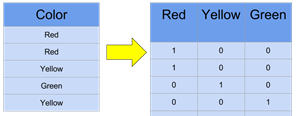

In [ ]:
df_2 = pd.get_dummies(dataframe, columns=['town','flat_type','storey_range','flat_model'])
df_2.head()

In [ ]:
len(df_2.columns)

We see that now we have expanded the number of columns to 75.  Of which 74 columns will be used as features to train our model.  Can you guess which column is not used as a feature?

That's right.  Remember, resale_price is our "target" (some call it label) that we are trying to predict, so this is not a feature.  The following will split the dataset into features and traget. We typically pre-fix the features array with a "X" and the target array with a "y".

In [ ]:
X = df_2.drop('resale_price',axis =1)
y = df_2['resale_price']
X=X.values
y=y.values

Next we will split the dataset such that 30% is used for evaluating the model and 70% is used for training the model.

In [ ]:
#splitting Train and Test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
# Let us print the first element in the array to have a look at the data
print(X_train[0])

Next, we will use a MinMax scaler to transform the dataset. This scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.  Many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed. 

In [ ]:
#Standard scaler - fit&transform on train, fit only on test
s_scaler = MinMaxScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))

Let us take a look at the transformed data

In [ ]:
print(X_train[0])

### Linear Regression

In [ ]:
# Multiple Liner Regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
#evaluate the model (intercept and slope)
print(regressor.intercept_)
print(regressor.coef_)
#predicting the test set result
y_pred = regressor.predict(X_test)

In [ ]:
#compare actual output values with predicted values
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

In [ ]:
# evaluate the performance of the algorithm (MAE - MSE - RMSE)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


### K Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(algorithm='brute')
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

### Ridge Regression


In [ ]:
from sklearn.linear_model import Ridge

###
### add code to create Ridge regression
###

rr.fit(X_train,y_train)
predictions = rr.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

### Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
###
### add code to create Lasso regression
###

model_lasso.fit(X_train,y_train)
predictions = model_lasso.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

### Elastic Net Regression

In [ ]:
from sklearn.linear_model import ElasticNet
###
### add code to create Elastic Net regression
###

model_enet.fit(X_train,y_train)
predictions = model_enet.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


### Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
# having 9 neurons is based on the number of available features
model = Sequential()

###
### add code to create your neural network regression
###

model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')

In [ ]:
model.summary() 

In [ ]:
# Train the model
model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=8,
    shuffle=True,
    verbose=2
)

In [ ]:
predictions = model.predict(X_test, verbose=0)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))